# Pillar deflection single video analysis
#### Author: Youngbin Kim
#### Last updated: 02/22/24

This notebook goes over basic analysis of single videos pillar deflection functional assessment. To analyze multiple videos in a single run, please check the batch analysis notebook.

## Import packages

In [20]:
import beatprofiler as bp
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np

## Analyze data

In [21]:
# file path of your video
file_path = r"sample videos/bf tissue 20fps.mov"

# create a video object to handle reading the video and extracting trace
video = bp.TissueVideo(file_path=file_path, frame_rate=20, name="testvid")

# extract trace
video.calculate_trace(bounding_box = r"C:\Program Files (x86)\BeatProfiler\_internal\yolo_models\pillar det milliPillar.pt",
                      anchor_method = "grid", 
                      n=25, 
                      window_size=30,
                      savevid=True,
                      savevid_path = "tracked points.mp4"
                     )

# calculate mask
video.calculate_mask(method="YOLOv8 segmentation", 
                     yolo_seg_model = r"C:\Program Files (x86)\BeatProfiler\_internal\yolo_models\tissue seg milliPillar.pt"
                    )

# calculate tissue width
video.calculate_width()

# create a trace object to handle drift correction and peak identification/analysis
trace = bp.TissueTrace(data=video.trace[:400],
                       frame_rate=video.frame_rate,
                       width_px=video.width,
                       area=video.area,
                       resting_dist_px=video.resting_dist, 
                       um_per_pix=6.5, 
                       unloaded_dist=3000, 
                       force_disp_coeff=2.1)

# detect and analyze beats
trace.analyze_peaks(min_prominence=0.2)


0: 576x1024 2 1s, 23.5ms
Speed: 40.0ms preprocess, 23.5ms inference, 7.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 576x1024 1 t, 19.0ms
Speed: 30.0ms preprocess, 19.0ms inference, 7.5ms postprocess per image at shape (1, 3, 1024, 1024)


## Plot and Visualize data

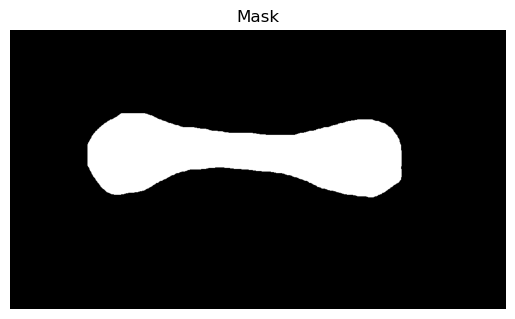

In [22]:
# mask show
plt.imshow(video.mask, cmap="gray")
plt.axis('off')
plt.title("Mask");

Text(0, 0.5, 'Deflection [μm]')

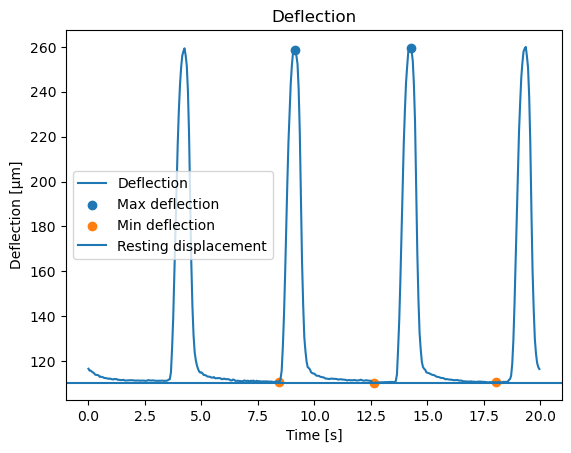

In [23]:
# Plot the deflection
plt.plot(np.arange(len(trace.df_f0))/trace.frame_rate, trace.df_f0, label="Deflection")
plt.scatter(trace.peaks/trace.frame_rate,trace.df_f0[trace.peaks], label = "Max deflection")
plt.scatter(trace.valleys/trace.frame_rate,trace.df_f0[trace.valleys], label = "Min deflection")
plt.axhline(y=trace.unloaded_dist - trace.resting_dist, label="Resting displacement")
plt.legend()
plt.title("Deflection")
plt.xlabel("Time [s]")
plt.ylabel("Deflection [μm]")

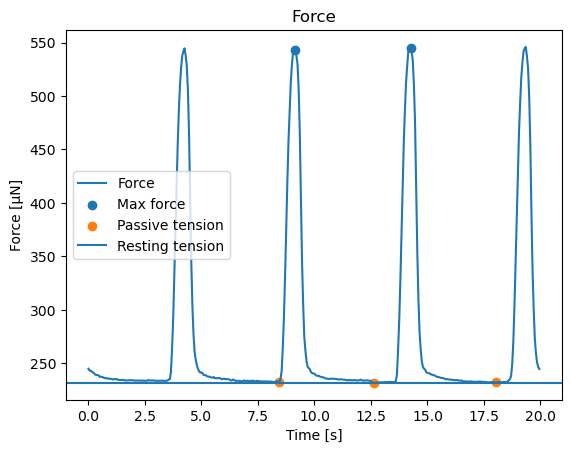

In [24]:
# Plot the force
plt.plot(np.arange(len(trace.force))/trace.frame_rate, trace.force, label="Force")
plt.scatter(trace.peaks/trace.frame_rate,trace.force[trace.peaks], label = "Max force")
plt.scatter(trace.valleys/trace.frame_rate,trace.force[trace.valleys], label = "Passive tension")
plt.axhline(y=trace.resting_tension, label="Resting tension")
plt.legend()
plt.title("Force")
plt.xlabel("Time [s]")
plt.ylabel("Force [μN]");

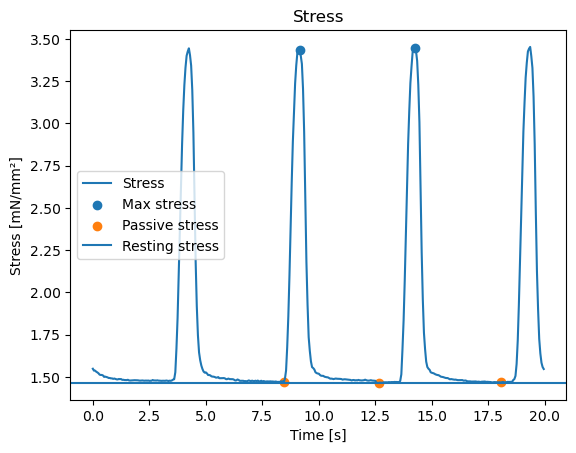

In [25]:
# Plot the stress
plt.plot(np.arange(len(trace.stress))/trace.frame_rate, trace.stress, label="Stress")
plt.scatter(trace.peaks/trace.frame_rate,trace.stress[trace.peaks], label = "Max stress")
plt.scatter(trace.valleys/trace.frame_rate,trace.stress[trace.valleys], label = "Passive stress")
plt.axhline(y=trace.resting_tension/1000/trace.xc_area, label="Resting stress")
plt.legend()
plt.title("Stress")
plt.xlabel("Time [s]")
plt.ylabel("Stress [mN/mm²]");

Text(0, 0.5, 'Velocity [μm/s]')

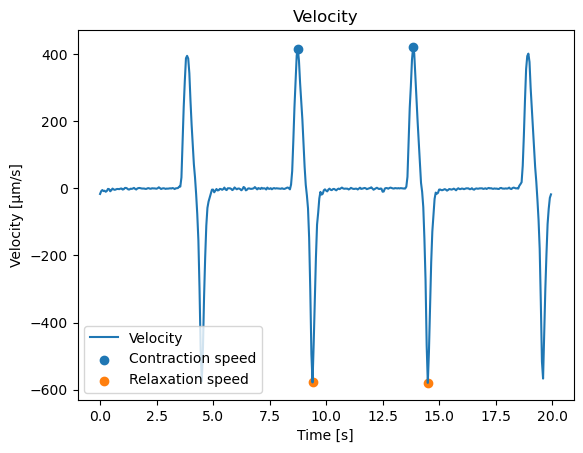

In [26]:
# Plot the velocity
plt.plot(np.arange(len(trace.velocity))/trace.frame_rate, trace.velocity, label="Velocity")
plt.scatter(trace.contraction_speeds_index/trace.frame_rate, trace.velocity[trace.contraction_speeds_index], label = "Contraction speed")
plt.scatter(trace.relaxation_speeds_index/trace.frame_rate, trace.velocity[trace.relaxation_speeds_index], label = "Relaxation speed")
plt.legend()
plt.title("Velocity")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [μm/s]")

In [27]:
# summary
trace.feature_summary.dropna()

num beats                              2.000000e+00
beat frequency [bpm]                   1.176471e+01
RMSSD [s]                              5.100000e+00
cross sectional area [mm2]             1.581173e-01
tissue area [mm2]                      2.737589e+06
                                           ...     
max relaxation speed [um/s]            5.801733e+02
max tau [s]                            3.075461e-01
max total force [uN]                   5.445398e+02
max total stress [mN/mm2]              3.443897e+00
max work per contraction cycle [nJ]    5.778560e+01
Length: 90, dtype: float64

In [28]:
# peak summary
trace.peak_summary.dropna(how="all", axis=1)

,beat index,tau [s],fwhm [s],contract50 [s],relax50 [s],fw90m [s],contract90 [s],relax90 [s],deflection [um],auc [um*s],...,relaxation speed [um/s],active length [um],passive length [um],total force [uN],passive tension [uN],active force [uN],total stress [mN/mm2],passive stress [mN/mm2],active stress [mN/mm2],work per contraction cycle [nJ]
None,183,0.298690,0.651131,0.387854,0.263277,0.996794,0.553957,0.442837,147.710930,199.006348,...,578.793945,2741.618896,2889.329834,542.600281,232.407349,310.999634,3.431630,1.469841,1.966891,57.238557
None,285,0.307546,0.650693,0.380349,0.270344,0.999589,0.549640,0.449950,148.828366,193.469055,...,580.173340,2740.695312,2889.523682,544.539795,232.000269,312.939148,3.443897,1.467266,1.979158,57.785600
